# MODELING

## IMPORT PACKAGE

In [ ]:
#Import package
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
import time
# Import warning untuk mengabaikan pemberitahuan yang kurang penting
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Data

In [ ]:
#Membuat dataframe dari hasil seluruh tabel yang di join
train = pd.read_csv('apptrain_bureau_prev.csv')

In [ ]:
#Menampilkan dataframe
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: low,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle,PREV_PRODUCT_COMBINATION_POS household with interest,PREV_PRODUCT_COMBINATION_POS household without interest,PREV_PRODUCT_COMBINATION_POS industry with interest,PREV_PRODUCT_COMBINATION_POS industry without interest,PREV_PRODUCT_COMBINATION_POS mobile with interest,PREV_PRODUCT_COMBINATION_POS mobile without interest,PREV_PRODUCT_COMBINATION_POS other with interest,PREV_PRODUCT_COMBINATION_POS others without interest
0,100002,1,0,1,0,1,0,202500.0,12.915579,10.114579,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0
1,100003,0,0,0,0,0,0,270000.0,14.072864,10.482864,...,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,11.813030,8.817298,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,12.652944,10.298448,...,0.222222,0.0,0.111111,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0
4,100007,0,0,1,0,1,0,121500.0,13.148031,9.992665,...,0.000000,0.5,0.166667,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0


## ENCODING

In [ ]:
#Melihat informasi dataset train mengenai tipe data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304526 entries, 0 to 304525
Columns: 277 entries, SK_ID_CURR to PREV_PRODUCT_COMBINATION_POS others without interest
dtypes: bool(1), float64(234), int64(33), object(9)
memory usage: 641.5+ MB


In [ ]:
#Meremove kolom SK_ID_CURR karena sudah tidak digunakan
train = train.drop(['SK_ID_CURR'], axis = 1)

In [ ]:
#Mengkategorikan kembali variabel numerical untuk dataset train
nums_train=[i for i in train.columns if train[i].dtypes != 'object' and i not in ['TARGET']]
#Mengkategorikan kembali variabel categorical untuk dataset train
cats_train=[i for i in train.columns if train[i].dtypes == 'object']

In [ ]:
#Melihat informasi data categorical mengenau unique value
train[cats_train].describe().T

,count,unique,top,freq
NAME_TYPE_SUITE,304526,7,Unaccompanied,247108
NAME_INCOME_TYPE,304526,8,Working,157337
NAME_EDUCATION_TYPE,304526,5,Secondary / secondary special,216579
NAME_FAMILY_STATUS,304526,5,Married,194656
NAME_HOUSING_TYPE,304526,6,House / apartment,270239
OCCUPATION_TYPE,304526,19,unk,95433
WEEKDAY_APPR_PROCESS_START,304526,7,TUESDAY,53397
ORGANIZATION_TYPE,304526,58,Business Entity Type 3,67269
EMERGENCYSTATE_MODE,304526,3,No,157740


In [ ]:
#Membuat encoding data
def encoding_data(df):
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0
    col_le = []

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                col_le.append(col)

                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    print('encoded column =', col_le)

In [ ]:
# Melakukan one-hot encoding untuk categorical variable agar menjadi numerical variabel
train = pd.get_dummies(train)

print('shape: ', train.shape)

shape:  (304526, 385)


## CEK DATA

In [ ]:
#Membuat code untuk mendefine missing value
def missing_values_table(df):
  #Mengecek jumlah missing value
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [ ]:
#Mengecek missing value data keseluruhan
missing_values_table(train)

Your selected dataframe has 385 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Dataframe yang telah digabung tidak terindikasi missing value sehingga bisa dilanjutkan ke tahap berikutnya untuk mengidentifikasi data kolom mana saja yang akan digunakan dalam pemodelan ini.

## SPLIT DATA

Data train yang digunakan untuk pemodelan dibagi menjadi 70% train (latihan) dan 30% test.

In [ ]:
#Meremove kolom TARGET di X
X = train.drop(['TARGET'], axis=1)
#Membuat data TARGET di y
y= train['TARGET']

## FIND BEST FEATURES

In [ ]:
#Membuat dataframe baru dengan kolom di dataframe X
feats = X.columns

In [ ]:
#Import package sklearn.feature_selection
from sklearn.feature_selection import f_classif
#Membuat dataframe baru untuk mencari f-score
anova = pd.DataFrame(f_classif(X,y)).transpose()

In [ ]:
#Membuat kolom baru di dataframe
anova.columns = ['f-score','p-value']

In [ ]:
#Mengganti nama kolom
anova['columns_name'] = feats

In [ ]:
#Mengurutkan dataframe feature importance bisa dilihat dari nilai f-score terbesar ke terkecil
features_importance = anova.sort_values('f-score',ascending=False).head(30)

In [ ]:
#Menampilkan 30 variabel dari feature importance dengan f-score terbesar
features_importance.head(30)

,f-score,p-value,columns_name
30,8082.876464,0.000000e+00,EXT_SOURCE_2
31,7622.040251,0.000000e+00,EXT_SOURCE_3
64,2165.798025,0.000000e+00,BUREAU_DAYS_CREDIT
10,1894.568192,0.000000e+00,DAYS_BIRTH
163,1839.566259,0.000000e+00,PREV_NAME_CONTRACT_STATUS_Refused
78,1798.562702,0.000000e+00,BUREAU_CREDIT_ACTIVE_Closed
74,1489.060662,0.000000e+00,BUREAU_DAYS_CREDIT_UPDATE
67,1382.533726,6.285126e-302,BUREAU_DAYS_ENDDATE_FACT
11,1235.258373,4.636596e-270,DAYS_EMPLOYED
22,1133.754955,4.370197e-248,REGION_RATING_CLIENT_W_CITY


<Axes: ylabel='columns_name'>

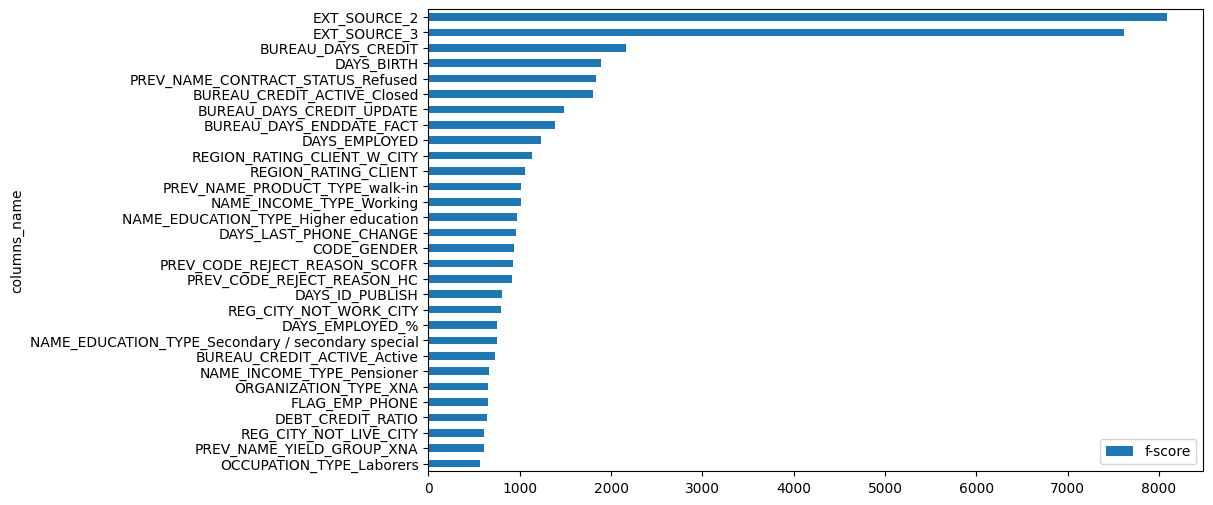

In [ ]:
#Membuat dataframe baru dari features importance
Features_sorted = features_importance.sort_values(by='f-score', ascending=True)
#Membuat plot dari 30 feature yang paling penting dengan f-score tertinggi
Features_sorted.plot(x='columns_name', y='f-score', kind='barh', figsize=(10, 6))

In [ ]:
# Menampilkan nama-nama kolom 30 features importance
features_importance['columns_name']

30                                          EXT_SOURCE_2
31                                          EXT_SOURCE_3
64                                    BUREAU_DAYS_CREDIT
10                                            DAYS_BIRTH
163                    PREV_NAME_CONTRACT_STATUS_Refused
78                           BUREAU_CREDIT_ACTIVE_Closed
74                             BUREAU_DAYS_CREDIT_UPDATE
67                              BUREAU_DAYS_ENDDATE_FACT
11                                         DAYS_EMPLOYED
22                           REGION_RATING_CLIENT_W_CITY
21                                  REGION_RATING_CLIENT
223                       PREV_NAME_PRODUCT_TYPE_walk-in
280                             NAME_INCOME_TYPE_Working
282                 NAME_EDUCATION_TYPE_Higher education
43                                DAYS_LAST_PHONE_CHANGE
1                                            CODE_GENDER
173                        PREV_CODE_REJECT_REASON_SCOFR
170                           P

Dari 30 features importance dengan f-score tertinggi diambil 25 variabel dengan f-score tertinggi. Kemudian dari diambilnya 25 variable tersebut, dikecualikan column yang nama akhirannya XNA. Hal itu karena XNA tidak memenuhi kriteria analisis dataset ini karena di data preparation di bagian code gender XNA telah dihapus karena yang memenuhi standar kriteria hanya Female dan Male. Oleh karena itu, di bagian ini dilakukan penyeleksian data dalam mengambil 25 variabel dengan mengecualikan XNA.

In [ ]:
# Membuat dataframe dengan 25 variable features importance
data = train[['TARGET','EXT_SOURCE_2','EXT_SOURCE_3','BUREAU_DAYS_CREDIT','DAYS_BIRTH','PREV_NAME_CONTRACT_STATUS_Refused',
              'BUREAU_CREDIT_ACTIVE_Closed','BUREAU_DAYS_CREDIT_UPDATE','BUREAU_DAYS_ENDDATE_FACT','DAYS_EMPLOYED','REGION_RATING_CLIENT_W_CITY',
              'REGION_RATING_CLIENT','PREV_NAME_PRODUCT_TYPE_walk-in','DAYS_LAST_PHONE_CHANGE','NAME_INCOME_TYPE_Working','NAME_EDUCATION_TYPE_Higher education',
             'CODE_GENDER','PREV_CODE_REJECT_REASON_SCOFR','PREV_CODE_REJECT_REASON_HC','DAYS_ID_PUBLISH','REG_CITY_NOT_WORK_CITY','DAYS_EMPLOYED_%',
             'DEBT_CREDIT_RATIO','BUREAU_CREDIT_ACTIVE_Active','REG_CITY_NOT_LIVE_CITY']].copy()

## Correlation with Target

Dari banyaknya data sebanyak 25, dilakukan seleksi kembali data mana saja yang paling baik untuk digunakan agar hasil dari pemodelan ini menghasilkan angka yang presisi dan akurasi yang baik. Dari penyeleksian itu, dilakukan tahap korelasi dengan target yang mana semakin besar angkanya maka memiliki pengaruh yang cukup besar untuk dilakukan pemodelan. Sedangkan,apabila tingkat korelasi sangat kecil terhadap
TARGET tidak berpengaruh signifikan dan tidak akan diperlukan
pada model

In [ ]:
# Find correlations with the target and sort
correlations = data.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(20))
print('\nMost Negative Correlations:\n', correlations.head(20))

Most Positive Correlations:
 REG_CITY_NOT_LIVE_CITY               0.044726
DEBT_CREDIT_RATIO                    0.045864
BUREAU_CREDIT_ACTIVE_Active          0.048926
REG_CITY_NOT_WORK_CITY               0.051151
DAYS_ID_PUBLISH                      0.051402
PREV_CODE_REJECT_REASON_HC           0.054776
PREV_CODE_REJECT_REASON_SCOFR        0.055030
CODE_GENDER                          0.055237
DAYS_LAST_PHONE_CHANGE               0.055876
NAME_INCOME_TYPE_Working             0.057612
PREV_NAME_PRODUCT_TYPE_walk-in       0.057664
REGION_RATING_CLIENT                 0.058908
REGION_RATING_CLIENT_W_CITY          0.060903
DAYS_EMPLOYED                        0.063561
BUREAU_DAYS_ENDDATE_FACT             0.067227
BUREAU_DAYS_CREDIT_UPDATE            0.069757
PREV_NAME_CONTRACT_STATUS_Refused    0.077489
DAYS_BIRTH                           0.078632
BUREAU_DAYS_CREDIT                   0.084035
TARGET                               1.000000
Name: TARGET, dtype: float64

Most Negative Correla

## Weight of Evidence

Dari 25 data features importance juga dilakukan penyeleksian kembali menggunakan metode WOE. Penyeleksian ini dilakukan dengan metode Weight of Evidence (WoE) dan Information Value (IV) adalah tahapan atau teknik sederhana
dan cukup baik untuk melakukan transformasi dan pemilihan variabel. WOE dan IV memiliki
hubungan yang cukup besar dengan teknik pemodelan regresi logistik. Teknik ini kerap
digunakan dalam penilaian kredit.

In [ ]:
#Melihat info data beserta tipenya
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304526 entries, 0 to 304525
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   TARGET                                304526 non-null  int64  
 1   EXT_SOURCE_2                          304526 non-null  float64
 2   EXT_SOURCE_3                          304526 non-null  float64
 3   BUREAU_DAYS_CREDIT                    304526 non-null  float64
 4   DAYS_BIRTH                            304526 non-null  int64  
 5   PREV_NAME_CONTRACT_STATUS_Refused     304526 non-null  float64
 6   BUREAU_CREDIT_ACTIVE_Closed           304526 non-null  float64
 7   BUREAU_DAYS_CREDIT_UPDATE             304526 non-null  float64
 8   BUREAU_DAYS_ENDDATE_FACT              304526 non-null  float64
 9   DAYS_EMPLOYED                         304526 non-null  float64
 10  REGION_RATING_CLIENT_W_CITY           304526 non-null  int64  
 11  

In [ ]:
#Mendefine iv_woe
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
#Melihat hasil iv dan woe
iv, woe = iv_woe(data = data, target = 'TARGET', bins=10, show_woe = True)
print(iv)
print(woe)

Information value of EXT_SOURCE_2 is 0.307192
       Variable                  Cutoff      N  Events  % of Events  \
0  EXT_SOURCE_2  (-0.0009999183, 0.215]  30453    5614     0.227601   
1  EXT_SOURCE_2          (0.215, 0.339]  30453    3691     0.149639   
2  EXT_SOURCE_2           (0.339, 0.44]  30453    3037     0.123125   
3  EXT_SOURCE_2           (0.44, 0.512]  30452    2549     0.103341   
4  EXT_SOURCE_2          (0.512, 0.566]  30455    2271     0.092070   
5  EXT_SOURCE_2          (0.566, 0.608]  30457    2025     0.082097   
6  EXT_SOURCE_2          (0.608, 0.646]  30449    1787     0.072448   
7  EXT_SOURCE_2          (0.646, 0.682]  30450    1496     0.060650   
8  EXT_SOURCE_2          (0.682, 0.722]  30452    1285     0.052096   
9  EXT_SOURCE_2          (0.722, 0.855]  30452     911     0.036933   

   Non-Events  % of Non-Events       WoE        IV  
0       24839         0.088755 -0.941712  0.130753  
1       26762         0.095626 -0.447778  0.024186  
2       27416

Information value of BUREAU_DAYS_ENDDATE_FACT is 0.069979
                   Variable                Cutoff      N  Events  % of Events  \
0  BUREAU_DAYS_ENDDATE_FACT   (-1061.0, -883.875]  30414    2023     0.082016   
1  BUREAU_DAYS_ENDDATE_FACT    (-1266.0, -1061.0]  30479    1848     0.074921   
2  BUREAU_DAYS_ENDDATE_FACT    (-1559.2, -1266.0]  30465    1786     0.072407   
3  BUREAU_DAYS_ENDDATE_FACT         (-220.0, 0.0]  91325    9702     0.393335   
4  BUREAU_DAYS_ENDDATE_FACT      (-488.5, -220.0]  30477    2899     0.117530   
5  BUREAU_DAYS_ENDDATE_FACT      (-698.0, -488.5]  30404    2454     0.099489   
6  BUREAU_DAYS_ENDDATE_FACT  (-8376.501, -1559.2]  30456    1750     0.070948   
7  BUREAU_DAYS_ENDDATE_FACT    (-883.875, -698.0]  30506    2204     0.089354   

   Non-Events  % of Non-Events       WoE        IV  
0       28391         0.101447  0.212627  0.004132  
1       28631         0.102305  0.311522  0.008531  
2       28679         0.102476  0.347323  0.010444  


Information value of REG_CITY_NOT_WORK_CITY is 0.032307
                 Variable Cutoff       N  Events  % of Events  Non-Events  \
0  REG_CITY_NOT_WORK_CITY      0  234292   17187     0.696789      217105   
1  REG_CITY_NOT_WORK_CITY      1   70234    7479     0.303211       62755   

   % of Non-Events       WoE        IV  
0         0.775763  0.107364  0.008479  
1         0.224237 -0.301725  0.023828  
Information value of DAYS_EMPLOYED_% is 0.057561
          Variable            Cutoff      N  Events  % of Events  Non-Events  \
0  DAYS_EMPLOYED_%  (-0.001, 0.0287]  30453    3245     0.131558       27208   
1  DAYS_EMPLOYED_%  (0.0287, 0.0548]  30453    3374     0.136787       27079   
2  DAYS_EMPLOYED_%  (0.0548, 0.0709]  30452    2393     0.097016       28059   
3  DAYS_EMPLOYED_%  (0.0709, 0.0774]  30453    2007     0.081367       28446   
4  DAYS_EMPLOYED_%  (0.0774, 0.0911]  30452    2343     0.094989       28109   
5  DAYS_EMPLOYED_%   (0.0911, 0.123]  30453    2854     0.11

In [ ]:
#Melihat iv dan mengurutkan dari hasil terkecil
iv.sort_values('IV')

,Variable,IV
0,PREV_CODE_REJECT_REASON_SCOFR,0.000000
0,REG_CITY_NOT_LIVE_CITY,0.022548
0,REG_CITY_NOT_WORK_CITY,0.032307
0,PREV_CODE_REJECT_REASON_HC,0.033241
0,DAYS_ID_PUBLISH,0.038278
0,CODE_GENDER,0.039216
0,PREV_NAME_PRODUCT_TYPE_walk-in,0.042114
0,NAME_INCOME_TYPE_Working,0.045393
0,DAYS_LAST_PHONE_CHANGE,0.047422
0,REGION_RATING_CLIENT,0.048104


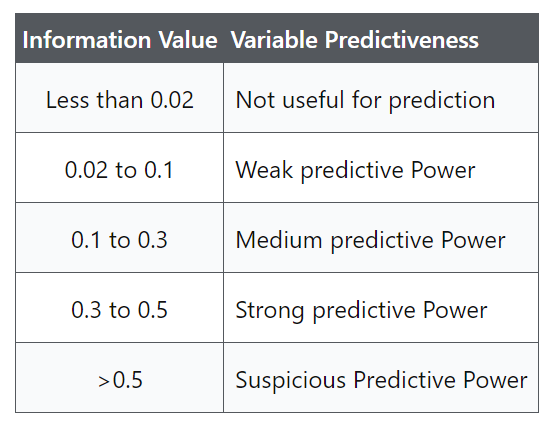


Dari tabel tersebut dapat dilihat jika hasil information valuenya kecil maka tidak akan berpengaruh terhadap pemodelan ini. Dengan demikian, dalam penyeleksian tersebut hanya diambil 20 variabel yang akan dijadikan untuk modeling. Dari hal itu, 5 variabel yang tidak akan digunakan akan didrop karena memiliki angka correlation dan information value yang kecil sehingga cenderung tidak akan digunakan di proses modeling.

In [ ]:
#Membuat dataframe 20 data untuk modeling dengan mendrop 5 kolom
data = data.drop(['PREV_CODE_REJECT_REASON_SCOFR','REG_CITY_NOT_LIVE_CITY','PREV_CODE_REJECT_REASON_HC','BUREAU_CREDIT_ACTIVE_Closed','DAYS_EMPLOYED_%'], axis = 1)

## SMOTE

Metode Synthetic Minority Over-sampling Technique (SMOTE) merupakan metode yang populer diterapkan dalam rangka menangani ketidak seimbangan kelas. Teknik ini mensintesis sampel baru dari kelas minoritas untuk menyeimbangkan dataset dengan cara sampling ulang sampel kelas minoritas.

In [ ]:
#Import package yang support terhadap proses SMOTE
from imblearn.over_sampling import SMOTE

In [ ]:
#Membuat data frame baru dari hasil SMOTE
smote = SMOTE()

In [ ]:
#Mencari SMOTE untuk variabel X dan Y
x_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
#Scale data
sc = StandardScaler()
x_smote = sc.fit_transform(x_smote)

## PEMODELAN

Pada tahap modeling dilakukan pengklasifikasian data. Klasifikasi merupakan pengelompokan data dimana data yang digunakan tersebut mempunyai kelas label atau target. Algoritma-algoritma yang digunakan untuk menyelesaikan masalah klasifikasi dikategorikan ke dalam supervised learning. Sebelum implementasi algoritma, perlu dilakukan pembagian data yaitu dengan membagi data train sebesar 70% dan data test 30%


In [ ]:
#Split data 70% data train 30% data test
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.3, random_state = 10)

Pada pemodelan ini dilakukan metode supervised learning yang mana digunakan 3 pemodelan yaitu Logistic Regression, Random Forest, dan XGBoost. Supervised learning merupakan sebuah pendekatan dengan proses subkategori atau tipe dari machine learning yang menggunakan data-data yang berlabel sebagai inputnya. Data-data tersebut diharapkan dapat ‘supervise’ atau melatih algoritma sehingga nantinya dapat digunakan untuk proses klasifikasi atau prediksi suatu data baru secara akurat.

###LOGISTIC REGRESSION

Logistic Regression digunakan untuk mendeskripsikan dan menjelaskan hubungan antara satu dependent binary variable satu atau lebih nominal, interval, ordinal hingga ratio level independent variabel.

In [ ]:
# Membuat dataframe baru terhadap LogisticRegression
log_reg = LogisticRegression()

In [ ]:
# Logistic Regression fit data X_train dan y_train
log_reg.fit(X_train,y_train)

LogisticRegression()

In [ ]:
#Membuat dataframe predict terhadap data test
y_pred = log_reg.predict(X_test)

In [ ]:
# Memprediksi tingkat errors
n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format("Logistic Regression errors",n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))

Logistic Regression errors: 7397
Accuracy Score :
0.9559482122013387
Confusion matrix :
[[83906   192]
 [ 7205 76613]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84098
           1       1.00      0.91      0.95     83818

    accuracy                           0.96    167916
   macro avg       0.96      0.96      0.96    167916
weighted avg       0.96      0.96      0.96    167916



In [ ]:
# Mencari FPR untuk variabel x dan TPR untuk variabel y
fpr, tpr, thresholds = roc_curve(y_tes, y_pred)

In [ ]:
# Mencari nilai auc
auc = roc_auc_score(y_test, y_pred)
# Nilai auc ditampilkan
auc

0.9558784464804899

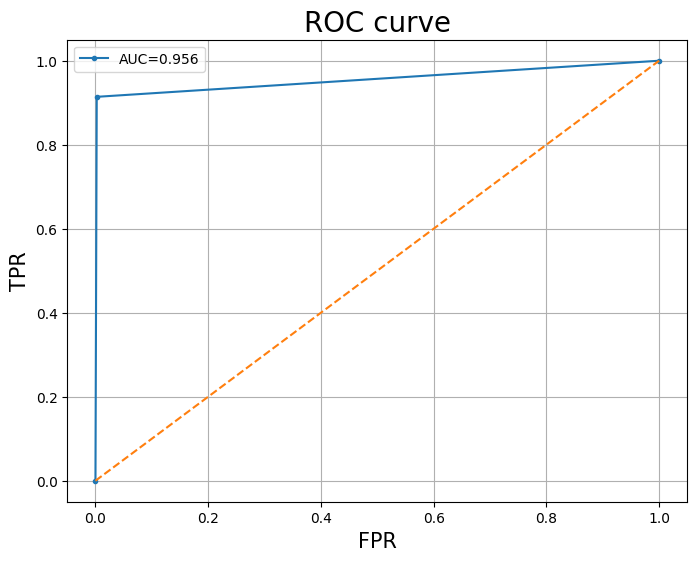

In [ ]:
# Plot gambar ukuran panjang 8 dan lebar 6
plt.figure(figsize=(8,6))
# Plot fpr, tpr untuk melihat AUC
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

### RANDOM FOREST

Random forest merupakan pemodelan untuk klasifikasi / regresi dengan membangun keputusan (decision tree) dan menghasilkan output berupa modus dari setiap kelas/rata-rata prediksi setiap pohon keputusan.

In [ ]:
# Membangun a random number generator
state = np.random.RandomState(42)

In [ ]:
# Membuat random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = state, verbose = 1, n_jobs = -1)

In [ ]:
# Random forest fit data X_train dan y_train
random_forest.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


RandomForestClassifier(n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x210E9323440,
                       verbose=1)

In [ ]:
#Membuat dataframe predict terhadap data test
y_pred_rf = random_forest.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


In [ ]:
# Melihat tingkat errors
n_errors = (y_pred_rf != y_test).sum()
# Run Classification Metrics
print("{}: {}".format("Random Forest errors",n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred_rf))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report :")
print(classification_report(y_test,y_pred_rf))

Random Forest errors: 7607
Accuracy Score :
0.9546975868886824
Confusion matrix :
[[84060    38]
 [ 7569 76249]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84098
           1       1.00      0.91      0.95     83818

    accuracy                           0.95    167916
   macro avg       0.96      0.95      0.95    167916
weighted avg       0.96      0.95      0.95    167916



In [ ]:
# Mencari FPR untuk variabel x dan TPR untuk variabel y
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

In [ ]:
# Mencari nilai auc
auc = roc_auc_score(y_tes, y_pred_rf)
# Nilai auc ditampilkan
auc

0.9546226736444504

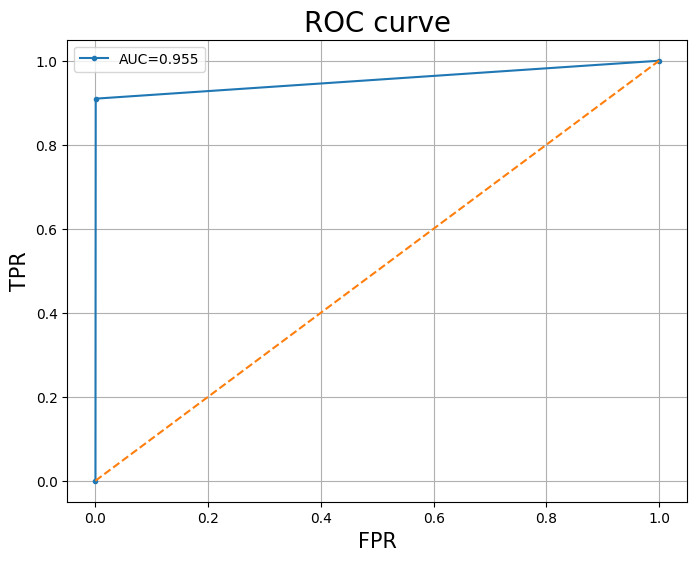

In [ ]:
# Memplot gambar ukuran panjang 8 dan lebar 6
plt.figure(figsize=(8,6))
# Memplot fpr dan tpr serta untuk melihat roc curve
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

### XGBoost

XGBoost adalah implementasi dari pohon keputusan yang didorong gradien yang dirancang untuk kecepatan dan kinerja serta metode pembelajaran ensemble yang menggabungkan prediksi dari beberapa model lemah untuk menghasilkan prediksi yang lebih kuat

In [ ]:
# Install XGBOOST in python
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import package Xgboost untuk classifier
from xgboost import XGBClassifier

In [ ]:
# Membuat XGR classifier dan fit terhadap X_train dan y_train
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# Membuat prediksi terhadap variabel X_test
y_pred_xgb = xgb_classifier.predict(X_test)

In [ ]:
# Melihat tingkat errors
n_errors = (y_pred_xgb != y_test).sum()
# Run Classification Metrics
print("{}: {}".format("Extreme Gradient Boost errors",n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred_xgb))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report :")
print(classification_report(y_test,y_pred_xgb))

Extreme Gradient Boost errors: 7505
Accuracy Score :
0.9553050334691155
Confusion matrix :
[[83579   519]
 [ 6986 76832]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     84098
           1       0.99      0.92      0.95     83818

    accuracy                           0.96    167916
   macro avg       0.96      0.96      0.96    167916
weighted avg       0.96      0.96      0.96    167916



In [ ]:
# Mencari FPR untuk variabel x dan TPR untuk variabel y
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)

In [ ]:
# Mencari nilai auc
auc = roc_auc_score(y_test, y_pred_xgb)
# Nilai auc ditampilkan
auc

0.9552406880623413

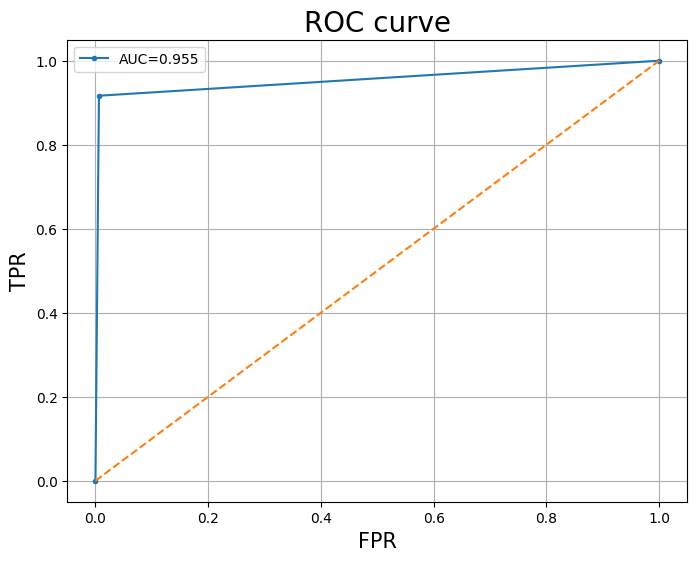

In [ ]:
# Plot gambar ukuran panjang 8 dan lebar 6
plt.figure(figsize=(8,6))
# Plot fpr, tpr, serta auc
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

## SUMMARY MODELING

1. Dari ketika model tersebut, logistic regression memiliki tingkat akurasi terbesar yaitu 95,6%
2. Tingkat precision dipegang oleh logistic regression dan Random forest yaitu 100%
3. Pada recall, model XGBoost memiliki persentase tertinggi yaitu 92%
3. Pada F1, model ketiga model memiliki persentase yang sama yaitu 95%
4. Score auc tertinggi, persentase tertingginya dipegang oleh model Logistic Regression.

Dari 5 perbandingan score tersebut dapat dilihat bahwa ketiganya menghasilkan pemodelan yang baik karena menghasilkan tingkat score yang rata-rata sekitar >90%. Akan tetapi, jika dibandingkan keseluruhannya maka Logistic Regression menghasilkan modeling yang baik dengan dimilikinya score tertinggi diantara 5 score (akurasi, precision, recall, F1, dan auc).

#EVALUATION

Evaluasi merupakan lagkah yang dilakukan dengan tujuan untuk meliihat seberapa baik performa dari model yang telah diujikan. Sehingga, dari beberapa opsi model yang ada dapat dipilih yang terbaik. Metode evaluasi yang digunakan adalah MAE (rata-rata dari selisih nilai aktual dan prediksi), MAPE(Persentase kesalahan rata-rata), dan MSE(rata-rata kesalahan kuadrat antara nilai aktual dan nilai prediksi).

##Logistic Regression Evaluation

In [ ]:
# Import package untuk mencari MAE, MSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Calulate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# CAlculate  MSE
mse = mean_squared_error(y_test, y_pred)

# Print MAPE, MAE, MSE
print("Logistic Regression Evaluation")
print("")
print("MAPE:", mape)
print("MAE:", mae)
print("MSE:", mse)

Logistic Regression Evaluation

MAPE: 5149545775596.98
MAE: 0.044051787798661236
MSE: 0.044051787798661236
RMS: 0.2098851776535476


##Random Forest Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred_rf)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_rf)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_rf)

# Print MAPE, MAE, MSE
print("Random Forest Evaluation")
print("")
print("MAPE:", mape)
print("MAE:", mae)
print("MSE:", mse)

Random Forest Evaluation

MAPE: 1019180934753.6056
MAE: 0.045302413111317566
MSE: 0.045302413111317566


##XGBoost Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [ ]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_xgb)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_xgb)

# Print MAPE, MAE, MSE
print ("XGBoost Evaluation")
print("")
print("MAPE:", mape)
print("MAE:", mae)
print("MSE:", mse)

XGBoost Evaluation

MAPE: 13919865924660.506
MAE: 0.04469496653088449
MSE: 0.04469496653088449
